True


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


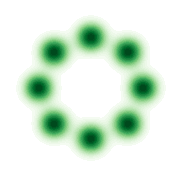

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
print(tf.test.is_gpu_available())
from scipy.stats import wasserstein_distance



####### generate dataset
covs=[]   
means=[]
y=[]
def gen_clusters(mean, cov=0.001, number=50):
    cov_matrix = [[cov,0],[0,cov]]
    for i,m in enumerate(mean):
      y.extend([i]*number)
      if i == 0:
        data = np.random.multivariate_normal(m, cov_matrix, number)
        covs.append(np.std(data,axis=0).tolist())
        means.append(np.mean(data,axis=0).tolist())
      else:
        d = np.random.multivariate_normal(m,cov_matrix,number)
        covs.append(np.std(d,axis=0).tolist())
        means.append(np.mean(d,axis=0).tolist())
        data = np.append(data, d,0)  
    return np.round(data,4)
  
def save_data(data,filename):
    with open(filename,'w') as file:
        for i in range(data.shape[0]):
            file.write(str(data[i,0])+','+str(data[i,1])+'\n')
            
def load_data(filename):
    data = []
    with open(filename,'r') as file:
        for line in file.readlines():
            data.append([ float(i) for i in line.split(',')])
    return np.array(data)

def show_scatter(data):
    x,y = data.T
    plt.figure(figsize=(2,2))
    flatui = ["#2ecc71"]
    plt.scatter(x,y,c="g",alpha=0.1)
    
    # sns.scatterplot(x,y,palette=sns.color_palette(flatui),alpha=0.5)
    plt.axis()
    plt.title("scatter")
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.show()
    
def show_scatter(data, color="Greens", epsilon=1e-9):
    
    data+=epsilon
    plt.figure(figsize=(3,3))
    bg_color=sns.color_palette(color, n_colors=256)[0]
    ax=sns.kdeplot(data[:,0],data[:,1], shade=True, cmap=color, n_levels=30)
    plt.axis('off')
    plt.show()


mean = []
for i in range(8):
  mean.append([np.cos((2*np.pi/8)*i), np.sin((2*np.pi/8)*i)])
data = gen_clusters(mean,cov=1e-4,number=300)
show_scatter(data)

In [6]:
###### model
batch_size=data.shape[0]
z_dim = 2
units_g = 32
units_d = 32
# ========================== generator ===========================
z_in = tf.keras.layers.Input(shape=(z_dim, ))
inputs = tf.keras.layers.Dense(units_g)(z_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.LeakyReLU()(inputs)

inputs = tf.keras.layers.Dense(z_dim)(inputs)
generator = tf.keras.Model(z_in, inputs)
generator.summary()
sample_z = tf.random.uniform((batch_size,z_dim),minval=-1,maxval=1)
generator(sample_z).shape


# ========================== discriminator ===========================
x_in = tf.keras.layers.Input(shape=(z_dim, )) #
inputs = tf.keras.layers.Dense(units_d)(x_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.LeakyReLU()(inputs)

inputs = tf.keras.layers.Dense(z_dim)(inputs) 
discriminator = tf.keras.Model(x_in, inputs)
discriminator.summary()
discriminator(data).shape



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 290
Trainable params: 226
Non-trainable params: 64
____________________________________________________________

TensorShape([2400, 2])

In [7]:
##### traing step

lr = 5e-5
generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)



loss_obj = tf.nn.sigmoid_cross_entropy_with_logits
def loss_ones_fn(logits):
  y = tf.ones_like(logits)
  loss = loss_obj(y,logits)
  return loss
def loss_zeros_fn(logits):
  y = tf.zeros_like(logits)
  loss = loss_obj(y,logits)
  return loss



def gradient_penalty(real_data, generated_data):
    alpha = tf.random.uniform((batch_size,1,),minval=0,maxval=1,dtype=tf.float32)

    interpolated = alpha * real_data + (1 - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prob_interpolated = discriminator(interpolated)
        gradients = tape.gradient(prob_interpolated,interpolated)

    gradients = tf.reshape(gradients,(batch_size,-1))
    gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
    # Return gradient penalty
    return 0.1*tf.reduce_mean((gradients_norm - 1) ** 2)




@tf.function
def train(real_images, real_images2, _lambda=0.5):
    
    #train discriminator
    with tf.GradientTape() as discriminator_tape:
        z = tf.random.uniform((batch_size, z_dim),-1,1)
        x = generator(z)  
        x_fake = discriminator(x)
        
        z2 = tf.random.uniform((batch_size, z_dim),-1,1)
        x2 = generator(z2)  
        x_fake2 = discriminator(x2)     
        x_real = discriminator(real_images)


        loss = tf.losses.MSE(tf.reduce_mean(tf.square(x_fake - x_fake2), -1),0.0) \
        + tf.losses.MSE(tf.reduce_mean(tf.square(x_real - discriminator(real_images2)), -1),1.0)
        # Note that we do not add GP to D in 2DRing dataset.
        discriminator_loss = tf.reduce_mean(loss)
    discriminator_grads = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables )
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables ))
    
    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size, z_dim),-1,1)
        x = generator(z)
        x_fake = discriminator(x)
        
        z2 =tf.random.uniform((batch_size, z_dim),-1,1)
        x2 = generator(z2)  
        x_fake2 = discriminator(x2)     
        
        loss = tf.losses.MSE(tf.reduce_mean(tf.square(x_fake - x_fake2), -1),1.0) 
        generator_loss = tf.reduce_mean(loss)  
    generator_grads = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss,discriminator_loss



data = tf.cast(data,tf.float32)
train(data, tf.random.shuffle(data))


(<tf.Tensor: shape=(), dtype=float32, numpy=0.9951005>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7926404>)

epoch: 0 generator_loss: 0.9945715 discriminator_loss: 0.78317714


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


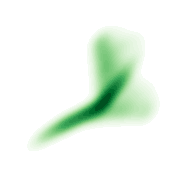

epoch: 1000 generator_loss: 0.579457 discriminator_loss: 0.52250004


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


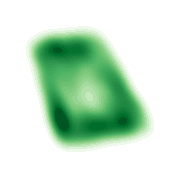

epoch: 2000 generator_loss: 0.54614127 discriminator_loss: 0.7689775


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


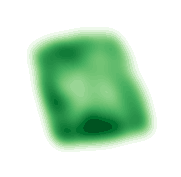

epoch: 3000 generator_loss: 0.61443305 discriminator_loss: 0.7995474


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


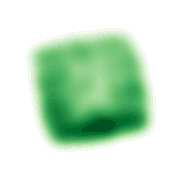

epoch: 4000 generator_loss: 0.6614458 discriminator_loss: 0.7023889


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


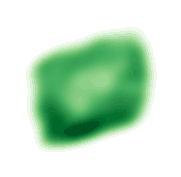

epoch: 5000 generator_loss: 0.590195 discriminator_loss: 0.6362099


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


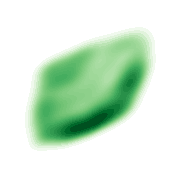

epoch: 6000 generator_loss: 0.5409991 discriminator_loss: 0.6094507


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


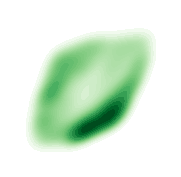

epoch: 7000 generator_loss: 0.5370534 discriminator_loss: 0.6108091


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


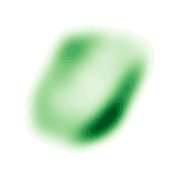

epoch: 8000 generator_loss: 0.52798116 discriminator_loss: 0.5937734


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


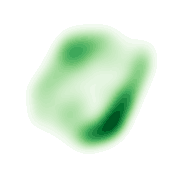

epoch: 9000 generator_loss: 0.5295989 discriminator_loss: 0.59401643


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


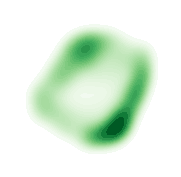

epoch: 10000 generator_loss: 0.51977557 discriminator_loss: 0.5797337


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


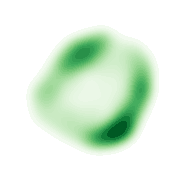

epoch: 11000 generator_loss: 0.52083707 discriminator_loss: 0.59956


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


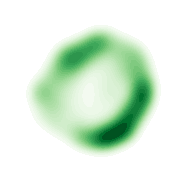

epoch: 12000 generator_loss: 0.51663595 discriminator_loss: 0.5910431


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


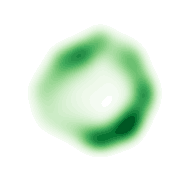

epoch: 13000 generator_loss: 0.51620287 discriminator_loss: 0.5975988


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


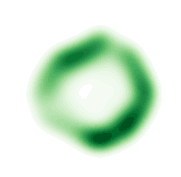

epoch: 14000 generator_loss: 0.5204268 discriminator_loss: 0.60527503


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


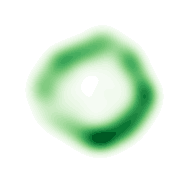

epoch: 15000 generator_loss: 0.52455676 discriminator_loss: 0.6095797


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


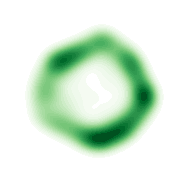

epoch: 16000 generator_loss: 0.5083074 discriminator_loss: 0.5951197


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


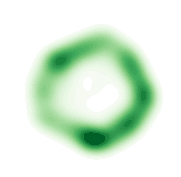

epoch: 17000 generator_loss: 0.5220597 discriminator_loss: 0.6052522


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


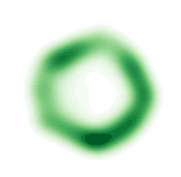

epoch: 18000 generator_loss: 0.52917343 discriminator_loss: 0.60680115


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


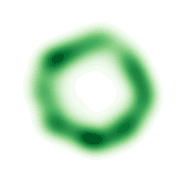

epoch: 19000 generator_loss: 0.513706 discriminator_loss: 0.61445636


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


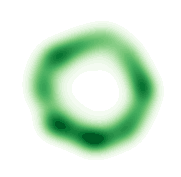

epoch: 20000 generator_loss: 0.51564914 discriminator_loss: 0.62001145


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


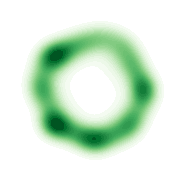

epoch: 21000 generator_loss: 0.5111333 discriminator_loss: 0.6087162


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


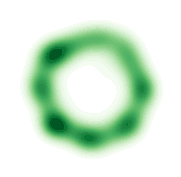

epoch: 22000 generator_loss: 0.517359 discriminator_loss: 0.61220175


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


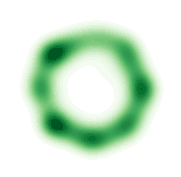

epoch: 23000 generator_loss: 0.5111622 discriminator_loss: 0.6154834


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


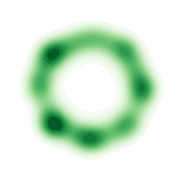

epoch: 24000 generator_loss: 0.5134732 discriminator_loss: 0.6125509


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


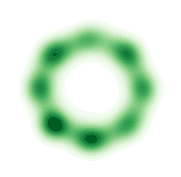

epoch: 25000 generator_loss: 0.50430787 discriminator_loss: 0.6152638


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


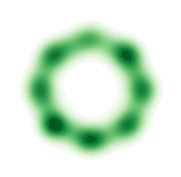

epoch: 26000 generator_loss: 0.52425504 discriminator_loss: 0.6220892


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


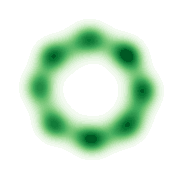

epoch: 27000 generator_loss: 0.5121988 discriminator_loss: 0.61762196


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


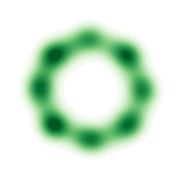

epoch: 28000 generator_loss: 0.50203234 discriminator_loss: 0.6142657


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


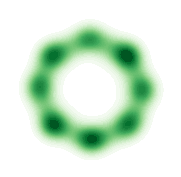

epoch: 29000 generator_loss: 0.5137307 discriminator_loss: 0.61755663


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


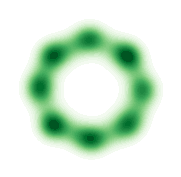

epoch: 30000 generator_loss: 0.5193505 discriminator_loss: 0.619228


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


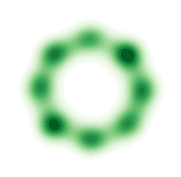

epoch: 31000 generator_loss: 0.5137865 discriminator_loss: 0.6166397


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


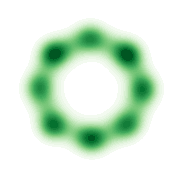

epoch: 32000 generator_loss: 0.5101615 discriminator_loss: 0.6053813


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


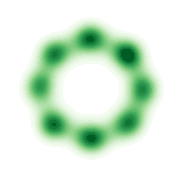

epoch: 33000 generator_loss: 0.50988334 discriminator_loss: 0.621807


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


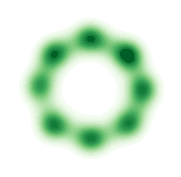

epoch: 34000 generator_loss: 0.51118207 discriminator_loss: 0.61329126


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


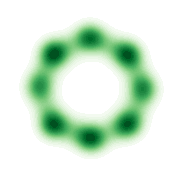

epoch: 35000 generator_loss: 0.50853574 discriminator_loss: 0.6185664


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


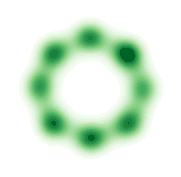

epoch: 36000 generator_loss: 0.524247 discriminator_loss: 0.6231922


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


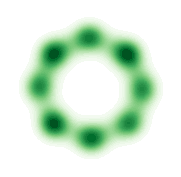

epoch: 37000 generator_loss: 0.51551086 discriminator_loss: 0.6123963


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


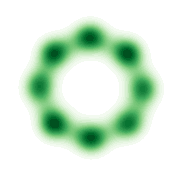

epoch: 38000 generator_loss: 0.51067716 discriminator_loss: 0.6335402


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


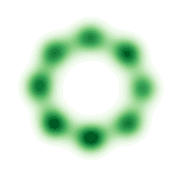

epoch: 39000 generator_loss: 0.5280539 discriminator_loss: 0.6236794


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


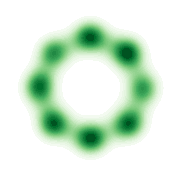

epoch: 40000 generator_loss: 0.51348567 discriminator_loss: 0.6269705


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


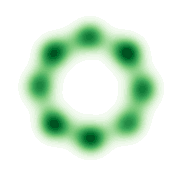

epoch: 41000 generator_loss: 0.5058518 discriminator_loss: 0.61122274


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


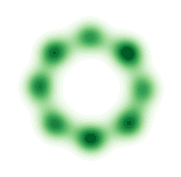

epoch: 42000 generator_loss: 0.50528085 discriminator_loss: 0.6064503


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


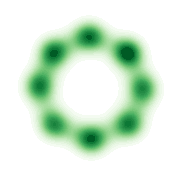

epoch: 43000 generator_loss: 0.5165287 discriminator_loss: 0.6202786


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


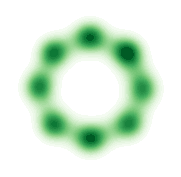

epoch: 44000 generator_loss: 0.52125055 discriminator_loss: 0.63193274


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


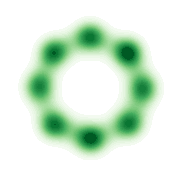

epoch: 45000 generator_loss: 0.5068634 discriminator_loss: 0.6322126


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


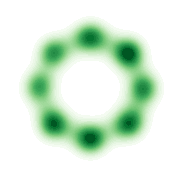

epoch: 46000 generator_loss: 0.510449 discriminator_loss: 0.6327582


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


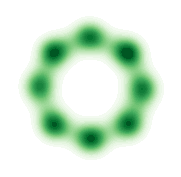

epoch: 47000 generator_loss: 0.51198274 discriminator_loss: 0.6227833


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


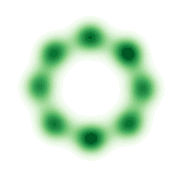

epoch: 48000 generator_loss: 0.5138822 discriminator_loss: 0.61616004


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


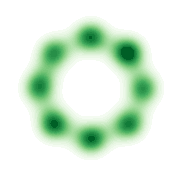

epoch: 49000 generator_loss: 0.5102135 discriminator_loss: 0.6168488


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


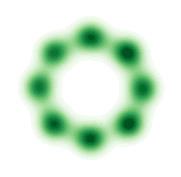

epoch: 50000 generator_loss: 0.520595 discriminator_loss: 0.62061685


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


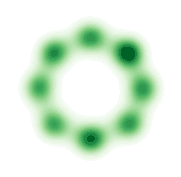

epoch: 51000 generator_loss: 0.52498394 discriminator_loss: 0.6353782


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


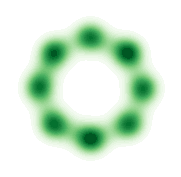

epoch: 52000 generator_loss: 0.51491576 discriminator_loss: 0.6178248


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


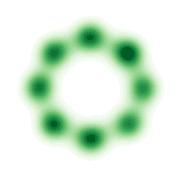

epoch: 53000 generator_loss: 0.5300708 discriminator_loss: 0.62205076


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


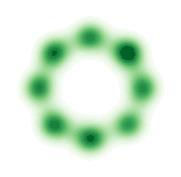

epoch: 54000 generator_loss: 0.5119842 discriminator_loss: 0.6271707


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


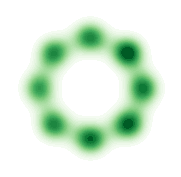

epoch: 55000 generator_loss: 0.5205748 discriminator_loss: 0.61687785


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


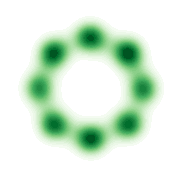

epoch: 56000 generator_loss: 0.52512664 discriminator_loss: 0.6091725


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


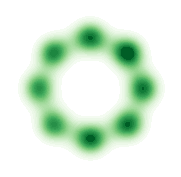

epoch: 57000 generator_loss: 0.5212916 discriminator_loss: 0.6098123


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


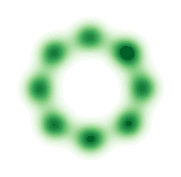

epoch: 58000 generator_loss: 0.5224704 discriminator_loss: 0.6137795


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


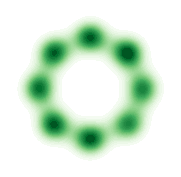

epoch: 59000 generator_loss: 0.5085772 discriminator_loss: 0.62527937


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


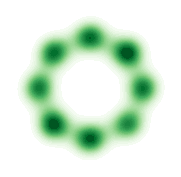

epoch: 60000 generator_loss: 0.5201552 discriminator_loss: 0.6308702


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


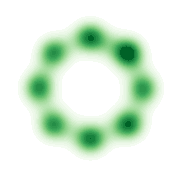

epoch: 61000 generator_loss: 0.5204622 discriminator_loss: 0.61303294


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


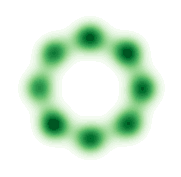

epoch: 62000 generator_loss: 0.51036954 discriminator_loss: 0.62600756


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


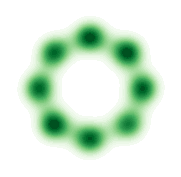

epoch: 63000 generator_loss: 0.52437747 discriminator_loss: 0.6273123


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


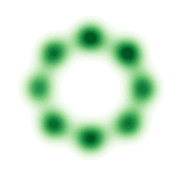

epoch: 64000 generator_loss: 0.510148 discriminator_loss: 0.60216755


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


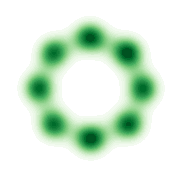

epoch: 65000 generator_loss: 0.50802475 discriminator_loss: 0.61325645


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


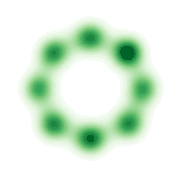

epoch: 66000 generator_loss: 0.51839924 discriminator_loss: 0.6170249


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


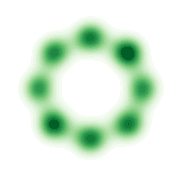

epoch: 67000 generator_loss: 0.52412504 discriminator_loss: 0.60919166


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


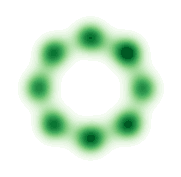

epoch: 68000 generator_loss: 0.5066724 discriminator_loss: 0.6259733


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


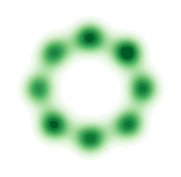

epoch: 69000 generator_loss: 0.52397114 discriminator_loss: 0.6115156


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


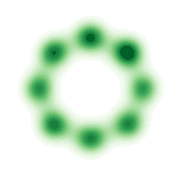

epoch: 70000 generator_loss: 0.51433635 discriminator_loss: 0.6157226


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


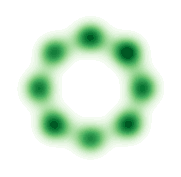

epoch: 71000 generator_loss: 0.5147125 discriminator_loss: 0.6188134


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


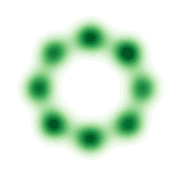

epoch: 72000 generator_loss: 0.52024215 discriminator_loss: 0.61410254


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


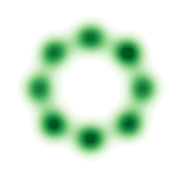

epoch: 73000 generator_loss: 0.5108111 discriminator_loss: 0.6186498


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


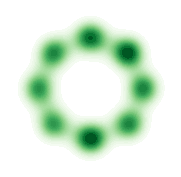

epoch: 74000 generator_loss: 0.5176213 discriminator_loss: 0.6229527


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


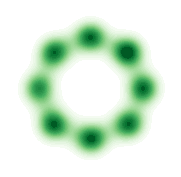

epoch: 75000 generator_loss: 0.50999194 discriminator_loss: 0.611861


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


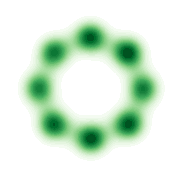

epoch: 76000 generator_loss: 0.51663107 discriminator_loss: 0.61819094


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


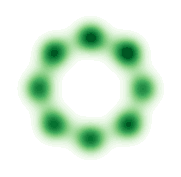

epoch: 77000 generator_loss: 0.50845915 discriminator_loss: 0.6090902


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


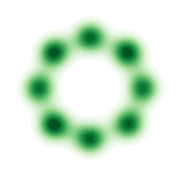

epoch: 78000 generator_loss: 0.5165455 discriminator_loss: 0.62017715


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


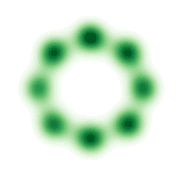

epoch: 79000 generator_loss: 0.5219944 discriminator_loss: 0.6219721


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


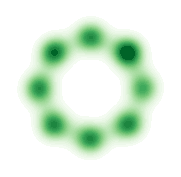

epoch: 80000 generator_loss: 0.52824545 discriminator_loss: 0.61864215


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


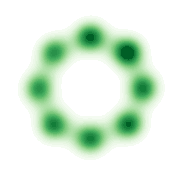

epoch: 81000 generator_loss: 0.5158263 discriminator_loss: 0.63712454


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


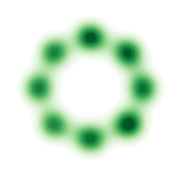

epoch: 82000 generator_loss: 0.5206831 discriminator_loss: 0.61355233


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


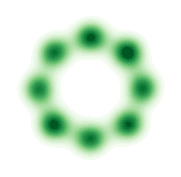

epoch: 83000 generator_loss: 0.5319876 discriminator_loss: 0.623045


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


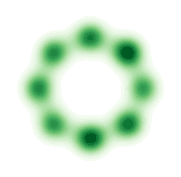

epoch: 84000 generator_loss: 0.5196665 discriminator_loss: 0.6254126


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


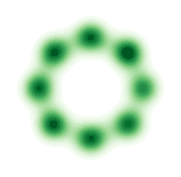

epoch: 85000 generator_loss: 0.5146548 discriminator_loss: 0.61100054


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


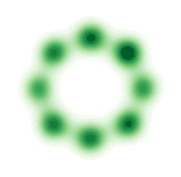

epoch: 86000 generator_loss: 0.5127595 discriminator_loss: 0.62001175


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


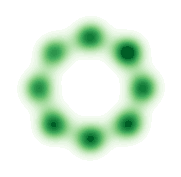

epoch: 87000 generator_loss: 0.51016146 discriminator_loss: 0.60701597


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


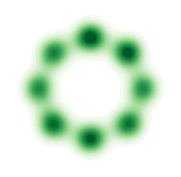

epoch: 88000 generator_loss: 0.5180577 discriminator_loss: 0.5986718


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


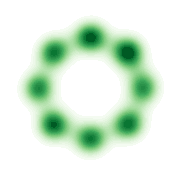

epoch: 89000 generator_loss: 0.5166827 discriminator_loss: 0.6113619


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


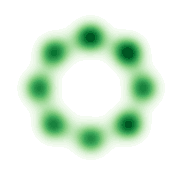

epoch: 90000 generator_loss: 0.51565534 discriminator_loss: 0.5995808


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


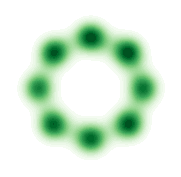

epoch: 91000 generator_loss: 0.52139366 discriminator_loss: 0.62040293


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


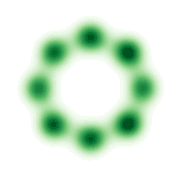

epoch: 92000 generator_loss: 0.5228372 discriminator_loss: 0.62541896


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


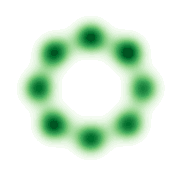

epoch: 93000 generator_loss: 0.5253449 discriminator_loss: 0.62538797


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


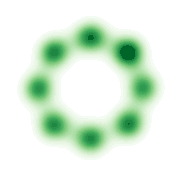

epoch: 94000 generator_loss: 0.4992094 discriminator_loss: 0.6098378


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


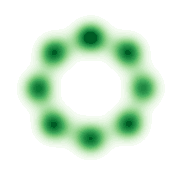

epoch: 95000 generator_loss: 0.52978414 discriminator_loss: 0.62046385


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


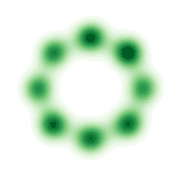

epoch: 96000 generator_loss: 0.5261716 discriminator_loss: 0.61475897


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


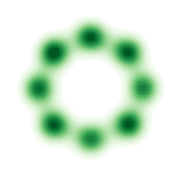

epoch: 97000 generator_loss: 0.5161756 discriminator_loss: 0.6179155


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


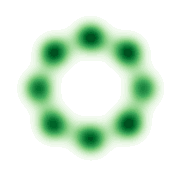

epoch: 98000 generator_loss: 0.5115999 discriminator_loss: 0.6088539


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


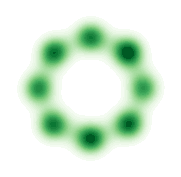

epoch: 99000 generator_loss: 0.51522386 discriminator_loss: 0.6188699


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


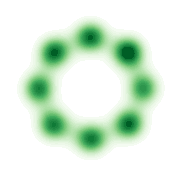

epoch: 100000 generator_loss: 0.53297627 discriminator_loss: 0.6249554


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


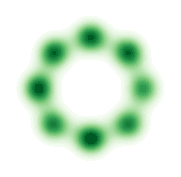

epoch: 101000 generator_loss: 0.52186483 discriminator_loss: 0.6087197


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


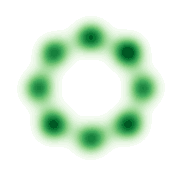

epoch: 102000 generator_loss: 0.5196414 discriminator_loss: 0.6275837


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


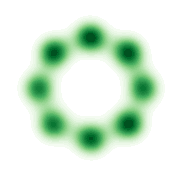

epoch: 103000 generator_loss: 0.53068733 discriminator_loss: 0.63219655


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


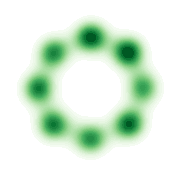

epoch: 104000 generator_loss: 0.5242223 discriminator_loss: 0.616683


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


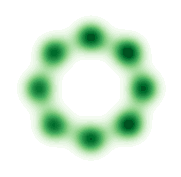

epoch: 105000 generator_loss: 0.5288565 discriminator_loss: 0.61682343


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


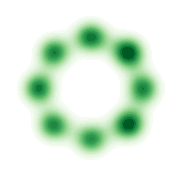

epoch: 106000 generator_loss: 0.53451896 discriminator_loss: 0.61019325


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


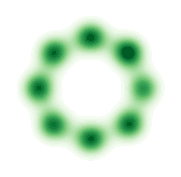

epoch: 107000 generator_loss: 0.5225384 discriminator_loss: 0.6116134


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


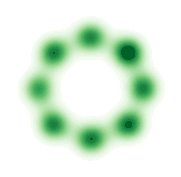

epoch: 108000 generator_loss: 0.5244786 discriminator_loss: 0.61361355


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


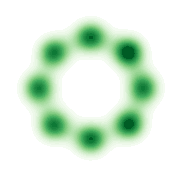

epoch: 109000 generator_loss: 0.5176005 discriminator_loss: 0.601524


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


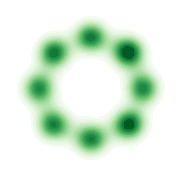

epoch: 110000 generator_loss: 0.5230265 discriminator_loss: 0.6175471


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


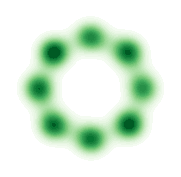

epoch: 111000 generator_loss: 0.5315525 discriminator_loss: 0.62293357


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


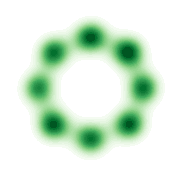

epoch: 112000 generator_loss: 0.5190568 discriminator_loss: 0.6154046


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


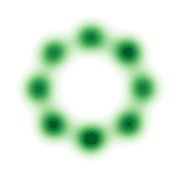

epoch: 113000 generator_loss: 0.525958 discriminator_loss: 0.6095576


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


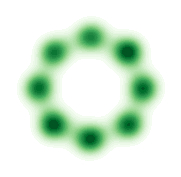

epoch: 114000 generator_loss: 0.53265977 discriminator_loss: 0.6016953


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


KeyboardInterrupt: ignored

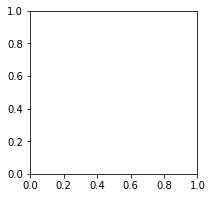

In [8]:
epochs = 10000000

for epoch in range(epochs):
    generator_loss,discriminator_loss = train(data, tf.random.shuffle(data))
    if epoch%1000 == 0:
        print("epoch:",epoch,
              "generator_loss:",generator_loss.numpy(), 
             "discriminator_loss:",discriminator_loss.numpy())  

        sample_z = tf.random.uniform((batch_size, z_dim),-1,1)
        sample_fake_image = generator(sample_z)
        show_scatter(sample_fake_image.numpy())